## This code takes in .wav files and turns them into a spectrogram, then saves them as a .png file

The screen resolution in inches is: 15.12x9.82


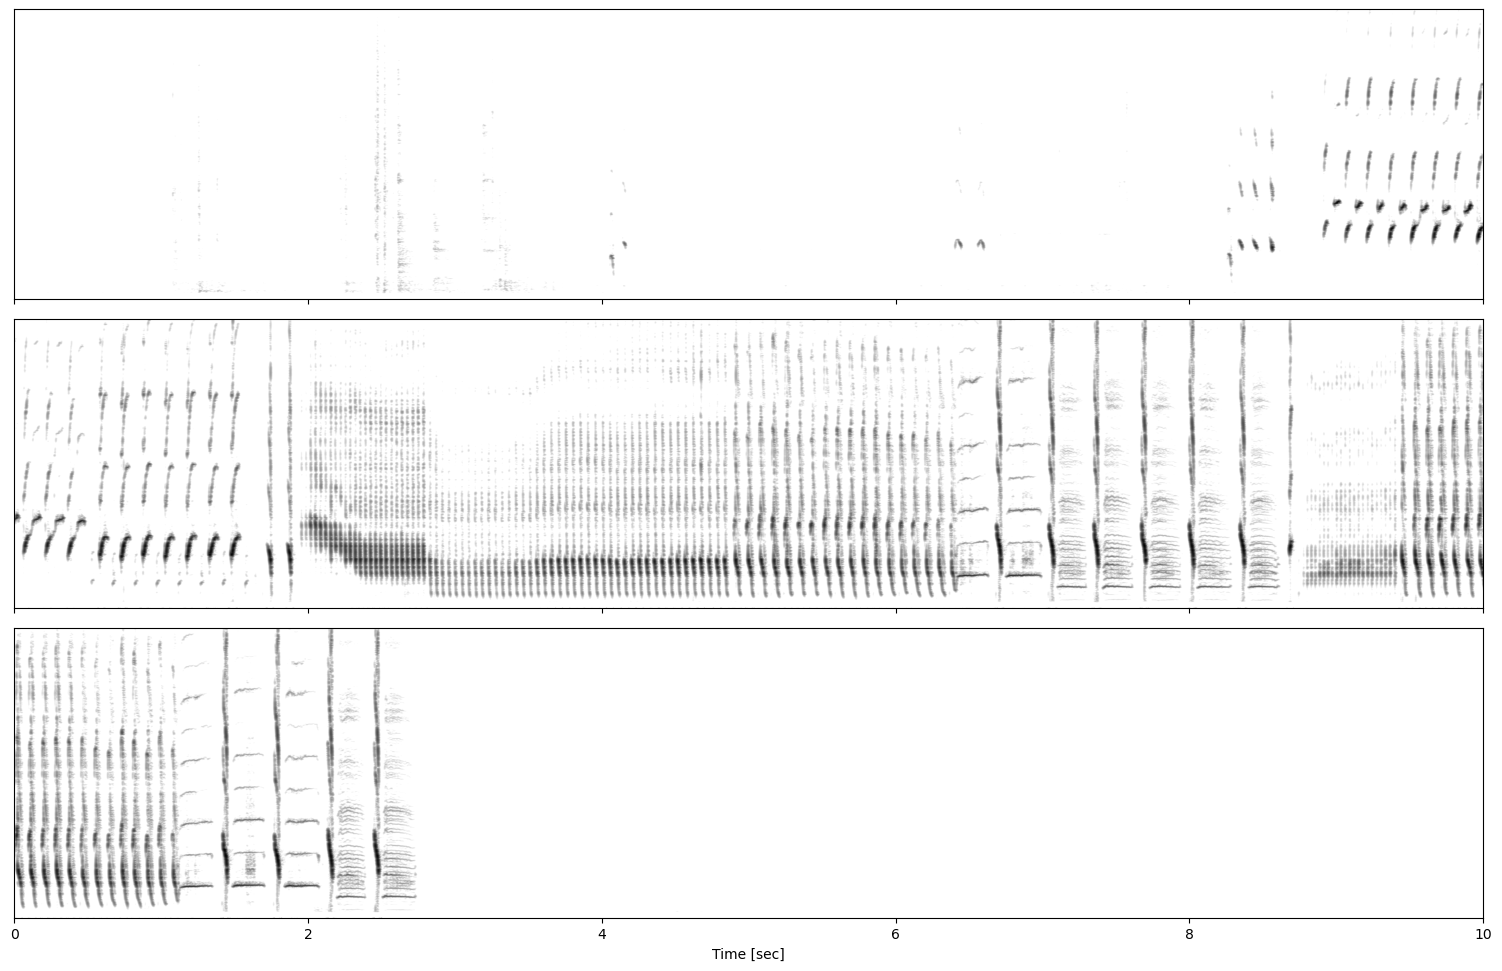

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import tkinter as tk
import os

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def plot_spectrograms_by_segment(file_path, segment_duration=10):
    try:
        # Load WAV file
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)  # Convert stereo to mono

        # High-pass filter
        b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)
        plt.subplots_adjust(hspace=-0.05)

        if num_segments == 1:
            axs = [axs]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=windows.gaussian(2048, std=2048/8), nperseg=2048, noverlap=(2048 - 119))
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            ax = axs[i]
            ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            ax.set_ylabel('')
            ax.set_yticks([])
            if i == num_segments - 1:
                ax.set_xlabel('Time [sec]')

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'  # <-- Replace with your file path
plot_spectrograms_by_segment(file_path)